In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import optuna
import logging

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
df = pd.read_csv("../data/processed/processed_data.csv", parse_dates=["timestamp"])

In [3]:
df.head()

,timestamp,city,aqi,pollution_level,pollution_class,temp,humidity,rain,wind_speed,wind_dir,pressure,cloud,pm2_5,pm10,co,no2,o3,so2
0,2023-01-01,Biên Hòa,133,Unhealthy for Sensitive,2,23.0,64,0.0,10.3,12,1010.3,100,65.0,95.0,993.0,84.4,25.0,37.5
1,2023-01-01,Buôn Ma Thuột,53,Moderate,1,17.7,88,0.3,7.7,101,968.4,100,13.6,23.2,485.0,1.8,105.0,2.2
2,2023-01-01,Bắc Ninh,146,Unhealthy for Sensitive,2,11.1,75,0.0,6.2,353,1023.5,0,52.4,74.7,678.0,8.8,58.0,15.4
3,2023-01-01,Cao Bằng,82,Moderate,1,10.8,83,0.0,4.6,162,996.6,100,31.9,45.5,528.0,6.4,45.0,7.6
4,2023-01-01,Cao Lãnh,86,Moderate,1,24.4,55,0.0,12.0,7,1013.9,100,21.8,32.2,693.0,23.0,47.0,3.3


In [4]:
cols_to_drop = ["pollution_level", "pollution_class"]
df = df.drop(columns=cols_to_drop, errors="ignore")

In [5]:
# Sort and handle duplicates/resampling
df = df.sort_values(by=["city", "timestamp"])

In [6]:
# Handle duplicates by taking the mean
df = df.groupby(["city", "timestamp"], observed=True).mean(numeric_only=True).reset_index()

In [7]:
df_feat = df.copy()

In [8]:
# Temporal & Social Context
# ==========================================
print("Processing Group 1: Temporal & Social...")

df_feat = df.copy()

# 1.1 Cyclical Hour
df_feat["hour"] = df_feat["timestamp"].dt.hour
df_feat["hour_sin"] = np.sin(2 * np.pi * df_feat["hour"] / 24)
df_feat["hour_cos"] = np.cos(2 * np.pi * df_feat["hour"] / 24)

# 1.2 Day Parts
def get_day_part(h):
    if 5 <= h < 10: return "morning"
    elif 10 <= h < 15: return "midday"
    elif 15 <= h < 18: return "afternoon"
    elif 18 <= h < 23: return "evening"
    else: return "night"

df_feat["day_part"] = df_feat["hour"].apply(get_day_part).astype("category")

# 1.3 Rush Hour
df_feat["is_rush_hour"] = df_feat["hour"].isin([7, 8, 9, 17, 18, 19]).astype(int)

# 1.4 Weekend
df_feat["dayofweek"] = df_feat["timestamp"].dt.dayofweek
df_feat["is_weekend"] = (df_feat["dayofweek"] >= 5).astype(int)

# 1.5 Season
df_feat["month"] = df_feat["timestamp"].dt.month
def month_to_season(m):
    if m in [12, 1, 2]: return "winter"
    elif m in [3, 4, 5]: return "spring"
    elif m in [6, 7, 8]: return "summer"
    else: return "autumn"

df_feat["season"] = df_feat["month"].apply(month_to_season).astype("category")

# Cyclical Month
df_feat["month_sin"] = np.sin(2 * np.pi * df_feat["month"] / 12)
df_feat["month_cos"] = np.cos(2 * np.pi * df_feat["month"] / 12)

# Convert City to Category
df_feat["city"] = df_feat["city"].astype("category")

Processing Group 1: Temporal & Social...


In [9]:
# Physics & Meteorology
# ==========================================
print("Processing Group 2: Physics & Meteo...")

# 2.1 Wind Vector
if "wind_speed" in df_feat.columns and "wind_dir" in df_feat.columns:
    wd_rad = df_feat["wind_dir"] * np.pi / 180
    df_feat["wind_x"] = df_feat["wind_speed"] * np.cos(wd_rad)
    df_feat["wind_y"] = df_feat["wind_speed"] * np.sin(wd_rad)
    df_feat = df_feat.drop(columns=["wind_dir"], errors="ignore")

# 2.2 Cumulative Rain (Washout effect)
if "rain" in df_feat.columns:
    df_feat["rain_sum_6h"] = df_feat.groupby("city", observed=True)["rain"].shift(1).rolling(6).sum().reset_index(0, drop=True)

# 2.3 Temperature Difference 24h (Inversion proxy)
if "temp" in df_feat.columns:
    temp_shifted = df_feat.groupby("city", observed=True)["temp"].shift(1)
    df_feat["temp_diff_24h"] = (
        temp_shifted.rolling(24).max() - temp_shifted.rolling(24).min()
    ).reset_index(0, drop=True)

# 2.4 Humidity-Temperature Interaction
if "humidity" in df_feat.columns and "temp" in df_feat.columns:
    df_feat["humid_x_temp"] = df_feat["humidity"] * df_feat["temp"]

Processing Group 2: Physics & Meteo...


In [10]:
# History & Trend
# ==========================================
print("Processing Group 3: History & Trend...")
target = "aqi"

# 3.1 Lag Features
lags = [1, 2, 3, 24]
for lag in lags:
    df_feat[f"aqi_lag_{lag}h"] = df_feat.groupby("city", observed=True)[target].shift(lag)

# 3.2 Rolling Statistics
aqi_shifted = df_feat.groupby("city", observed=True)[target].shift(1)

# Short-term (6h)
df_feat["aqi_rm_6h"] = aqi_shifted.rolling(6).mean().reset_index(0, drop=True)
df_feat["aqi_rs_6h"] = aqi_shifted.rolling(6).std().reset_index(0, drop=True)

# Long-term (24h)
df_feat["aqi_rm_24h"] = aqi_shifted.rolling(24).mean().reset_index(0, drop=True)

# 3.3 Short-term Trend
df_feat["aqi_trend_1h"] = df_feat["aqi_lag_1h"] - df_feat["aqi_lag_2h"]

pm25_col = "pm2_5"
if pm25_col in df_feat.columns:
    # Lags for PM2.5
    for lag in lags:
        df_feat[f"pm25_lag_{lag}h"] = df_feat.groupby("city", observed=True)[pm25_col].shift(lag)
    
    # Rolling for PM2.5
    pm25_shifted = df_feat.groupby("city", observed=True)[pm25_col].shift(1)
    df_feat["pm25_rm_6h"] = pm25_shifted.rolling(6).mean().reset_index(0, drop=True)
    df_feat["pm25_rm_24h"] = pm25_shifted.rolling(24).mean().reset_index(0, drop=True)

Processing Group 3: History & Trend...


In [11]:
# Composition
# ==========================================
print("Processing Group 4: Composition...")

if "pm10" in df_feat.columns and "pm2_5" in df_feat.columns:
    # Coarse Dust
    df_feat["coarse_dust"] = df_feat["pm10"] - df_feat["pm2_5"]
    # PM Ratio
    df_feat["pm_ratio"] = df_feat["pm2_5"] / (df_feat["pm10"] + 1e-6)

# Exogenous Lags
exo_cols = ["no2", "so2", "co", "o3", "coarse_dust", "pm_ratio", "pm10"]
for col in exo_cols:
    if col in df_feat.columns:
        df_feat[f"{col}_lag1h"] = df_feat.groupby("city", observed=True)[col].shift(1)

Processing Group 4: Composition...


In [12]:
print("Preparing Data for Training...")

df_model = df_feat.copy()

# Create Target (Shift -1 hour)
df_model["target_future"] = df_model.groupby("city", observed=True)["aqi"].shift(-1)

# Drop NaNs created by lags/rolling/shift
df_model = df_model.dropna()

# Define dates for split
val_start_date = pd.Timestamp("2025-08-01")
test_start_date = pd.Timestamp("2025-10-01")

# Split Data
train = df_model[df_model["timestamp"] < val_start_date]
val = df_model[(df_model["timestamp"] >= val_start_date) & (df_model["timestamp"] < test_start_date)]
test = df_model[df_model["timestamp"] >= test_start_date]

# Separate Features and Target
X_train = train.drop(columns=["timestamp", "target_future"])
y_train = train["target_future"]

X_val = val.drop(columns=["timestamp", "target_future"])
y_val = val["target_future"]

X_test = test.drop(columns=["timestamp", "target_future"])
y_test = test["target_future"]

# Save meta for plotting
test_meta = test[["city", "timestamp", "target_future"]]

print(f"Train Size: {len(X_train)} | Val Size: {len(X_val)} | Test Size: {len(X_test)}")

Preparing Data for Training...
Train Size: 768672 | Val Size: 49776 | Test Size: 45696


In [13]:
df_feat.columns

Index(['city', 'timestamp', 'aqi', 'temp', 'humidity', 'rain', 'wind_speed',
       'pressure', 'cloud', 'pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2', 'hour',
       'hour_sin', 'hour_cos', 'day_part', 'is_rush_hour', 'dayofweek',
       'is_weekend', 'month', 'season', 'month_sin', 'month_cos', 'wind_x',
       'wind_y', 'rain_sum_6h', 'temp_diff_24h', 'humid_x_temp', 'aqi_lag_1h',
       'aqi_lag_2h', 'aqi_lag_3h', 'aqi_lag_24h', 'aqi_rm_6h', 'aqi_rs_6h',
       'aqi_rm_24h', 'aqi_trend_1h', 'pm25_lag_1h', 'pm25_lag_2h',
       'pm25_lag_3h', 'pm25_lag_24h', 'pm25_rm_6h', 'pm25_rm_24h',
       'coarse_dust', 'pm_ratio', 'no2_lag1h', 'so2_lag1h', 'co_lag1h',
       'o3_lag1h', 'coarse_dust_lag1h', 'pm_ratio_lag1h', 'pm10_lag1h'],
      dtype='object')

In [14]:
# print("Starting Optuna Hyperparameter Tuning for AQI...")

# def objective(trial):
#     params = {
#         "objective": "reg:squarederror",
#         "n_estimators": 2000, 
#         "learning_rate": 0.05, 
#         "n_jobs": -1,
#         "random_state": 42,
#         "enable_categorical": True,
#         "early_stopping_rounds": 50,
        
#         # Tuning space
#         "max_depth": trial.suggest_int("max_depth", 5, 9),
#         "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
#         "subsample": trial.suggest_float("subsample", 0.6, 0.9),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
#         "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10.0, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
#     }

#     model = xgb.XGBRegressor(**params)
    
#     # Train on Train, Eval on Val (No leakage)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         verbose=False
#     )
    
#     preds = model.predict(X_val)
#     val_rmse = np.sqrt(mean_squared_error(y_val, preds))
#     return val_rmse

params = {
    "objective": "reg:squarederror",
    "n_estimators": 5000, 
    "learning_rate": 0.02, # Slow learning for better generalization
    "max_depth": 7,        # Moderate depth
    "min_child_weight": 1,
    "subsample": 0.8,      # Row subsampling to prevent overfitting
    "colsample_bytree": 0.8, # Column subsampling
    "reg_alpha": 0.1,      # L1 regularization
    "reg_lambda": 0.1,     # L2 regularization
    "n_jobs": -1,
    "random_state": 42,
    "enable_categorical": True,
    "early_stopping_rounds": 100 
}

In [15]:
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=20)

In [16]:
# print("Best Params:", study.best_params)
# print("Best Val RMSE:", study.best_value)

In [17]:
# print("Training Final Model for AQI...")

# final_params = {
#     "objective": "reg:squarederror",
#     "n_estimators": 5000, 
#     "learning_rate": 0.02, 
#     "n_jobs": -1,
#     "random_state": 42,
#     "enable_categorical": True,
#     "early_stopping_rounds": 100,
#     **study.best_params 
# }

In [18]:
model = xgb.XGBRegressor(**params)

model.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=200
)

print("Final Model Training Complete.")

[0]	validation_0-rmse:37.05091	validation_1-rmse:36.96225
[200]	validation_0-rmse:1.69526	validation_1-rmse:1.67274
[400]	validation_0-rmse:1.30314	validation_1-rmse:1.33487
[600]	validation_0-rmse:1.20525	validation_1-rmse:1.29426
[800]	validation_0-rmse:1.14344	validation_1-rmse:1.26994
[1000]	validation_0-rmse:1.09758	validation_1-rmse:1.25418
[1200]	validation_0-rmse:1.05700	validation_1-rmse:1.24218
[1400]	validation_0-rmse:1.02271	validation_1-rmse:1.23208
[1600]	validation_0-rmse:0.99143	validation_1-rmse:1.22481
[1800]	validation_0-rmse:0.96148	validation_1-rmse:1.21823
[2000]	validation_0-rmse:0.93371	validation_1-rmse:1.21285
[2200]	validation_0-rmse:0.90840	validation_1-rmse:1.20723
[2400]	validation_0-rmse:0.88432	validation_1-rmse:1.20053
[2600]	validation_0-rmse:0.86267	validation_1-rmse:1.19712
[2800]	validation_0-rmse:0.84170	validation_1-rmse:1.19410
[3000]	validation_0-rmse:0.82123	validation_1-rmse:1.18959
[3200]	validation_0-rmse:0.80202	validation_1-rmse:1.18734
[3

Evaluating Model...
>> TEST AQI RMSE: 0.6372
>> TEST AQI MAE : 0.3939
>> TEST AQI R2  : 0.9996


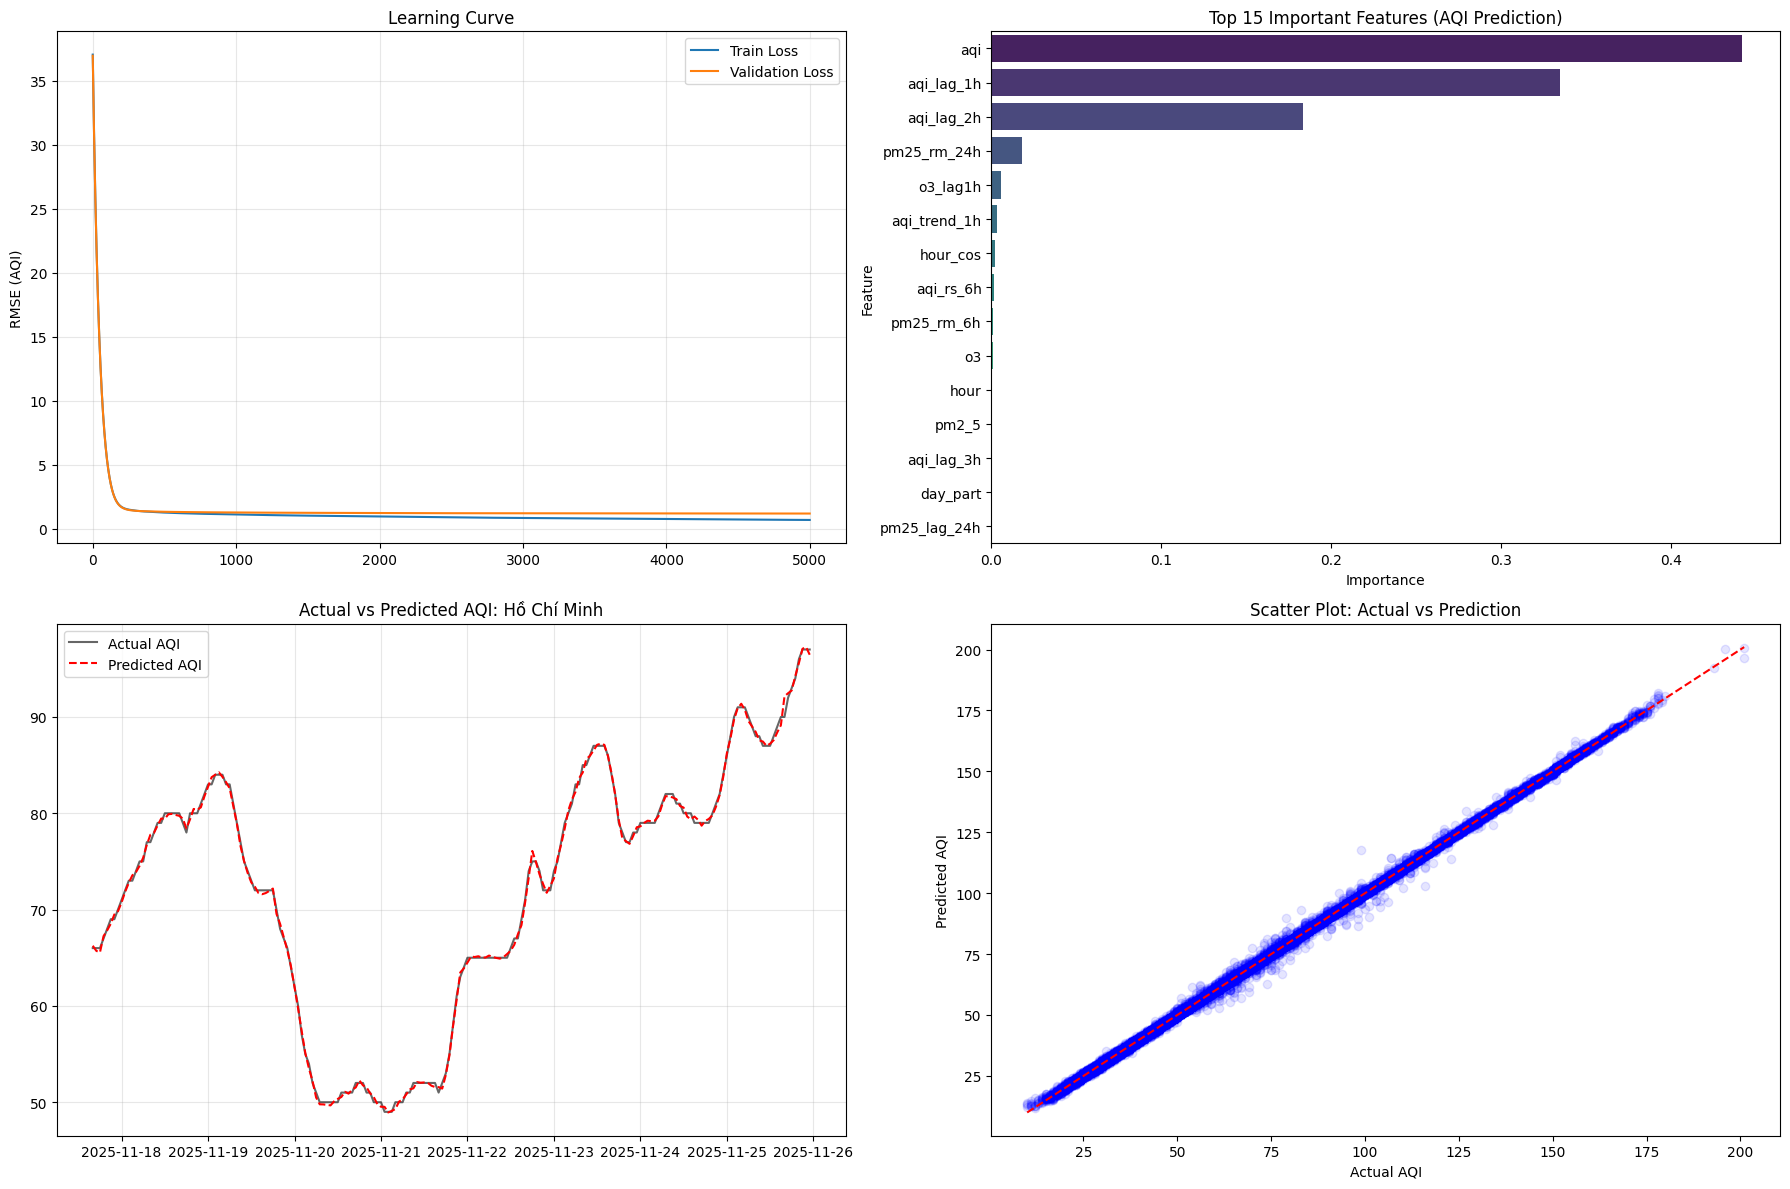

In [21]:
print("Evaluating Model...")

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f">> TEST AQI RMSE: {rmse:.4f}")
print(f">> TEST AQI MAE : {mae:.4f}")
print(f">> TEST AQI R2  : {r2:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot A: Learning Curve
results = model.evals_result()
if results:
    epochs = len(results["validation_0"]["rmse"])
    x_axis = range(0, epochs)
    axes[0, 0].plot(x_axis, results["validation_0"]["rmse"], label="Train Loss")
    axes[0, 0].plot(x_axis, results["validation_1"]["rmse"], label="Validation Loss")
    axes[0, 0].legend()
    axes[0, 0].set_ylabel("RMSE (AQI)")
    axes[0, 0].set_title("Learning Curve")
    axes[0, 0].grid(True, alpha=0.3)

# Plot B: Feature Importance
importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False).head(15)

sns.barplot(
    x="Importance", y="Feature", data=importance, 
    ax=axes[0, 1], palette="viridis", hue="Feature", legend=False
)
axes[0, 1].set_title("Top 15 Important Features (AQI Prediction)")

# Plot C: Forecast
sample_city = "Hồ Chí Minh" 
mask = test_meta["city"] == sample_city
if mask.sum() > 0:
    city_dates = test_meta.loc[mask, "timestamp"]
    city_actual = y_test[mask]
    city_preds = preds[mask]
    tail = 200
    axes[1, 0].plot(city_dates[-tail:], city_actual[-tail:], label="Actual AQI", color="black", alpha=0.6)
    axes[1, 0].plot(city_dates[-tail:], city_preds[-tail:], label="Predicted AQI", color="red", linestyle="--")
    axes[1, 0].set_title(f"Actual vs Predicted AQI: {sample_city}")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, "City not found in Test Set", ha="center")

# Plot D: Scatter
axes[1, 1].scatter(y_test, preds, alpha=0.1, color="blue")
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], "r--")
axes[1, 1].set_xlabel("Actual AQI")
axes[1, 1].set_ylabel("Predicted AQI")
axes[1, 1].set_title("Scatter Plot: Actual vs Prediction")

plt.tight_layout()
plt.show()

In [ ]:
model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    enable_categorical=True,
    early_stopping_rounds=100,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=200)


In [ ]:
preds = model.predict(X_test)
    
# Tính Metrics
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print(f">> TEST RMSE: {rmse:.4f}")
print(f">> TEST MAE : {mae:.4f}")

# 2. Vẽ biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- PLOT A: Learning Curve (Quá trình Train) ---
results = model.evals_result()
# validation_0 là Train, validation_1 là Val
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

axes[0, 0].plot(x_axis, results['validation_0']['rmse'], label='Train Loss')
axes[0, 0].plot(x_axis, results['validation_1']['rmse'], label='Validation Loss')
axes[0, 0].legend()
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Learning Curve (Train vs Validation)')
axes[0, 0].grid(True, alpha=0.3)

# --- PLOT B: Feature Importance (Top 15) ---
importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(15)

sns.barplot(x='Importance', y='Feature', data=importance, ax=axes[0, 1], palette='viridis', hue="Feature", legend=False)
axes[0, 1].set_title('Top 15 Most Important Features')

# --- PLOT C: Time Series Forecast (Chi tiết 1 thành phố) ---
# Chọn 1 thành phố tiêu biểu
sample_city = "Hồ Chí Minh" 

# Lọc dữ liệu của thành phố đó
mask = test_meta['city'] == sample_city
city_dates = test_meta.loc[mask, 'timestamp']
city_actual = y_test[mask]
city_preds = preds[mask]

# Chỉ vẽ 200 giờ cuối cùng
tail = 200
axes[1, 0].plot(city_dates[-tail:], city_actual[-tail:], label='Actual', color='black', alpha=0.6)
axes[1, 0].plot(city_dates[-tail:], city_preds[-tail:], label='Predicted', color='red', linestyle='--')
axes[1, 0].set_title(f'Actual vs Predicted: {sample_city} (Last {tail} hours)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)

# --- PLOT D: Scatter Plot (Độ chụm) ---
axes[1, 1].scatter(y_test, preds, alpha=0.1, color='blue')

# Vẽ đường chéo y=x (Lý tưởng)
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--')

axes[1, 1].set_xlabel('Actual PM2.5')
axes[1, 1].set_ylabel('Predicted PM2.5')
axes[1, 1].set_title('Scatter Plot: Actual vs Prediction')

plt.tight_layout()
plt.show()